# Quick Overview

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/docs/source/notebooks/extended_quick_start.ipynb)

In [15]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import textwrap

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
adata = sc.read(filename='BALF-COVID19.h5ad', 
                backup_url='https://zenodo.org/record/7535867/files/BALF-COVID19-Liao_et_al-NatMed-2020.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 63103 × 33538
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition'

## Run scCellFie

In [5]:
batch_key = 'sample' # Specify batch_key or leave as None

In [6]:
results = sccellfie.run_sccellfie_pipeline(adata, # Raw counts
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='n_counts', # Column where total counts per cells are stored in adata.obs
                                           process_by_group=False, # Whether to do the processing by cell groups
                                           groupby=None, # Column indicating cell groups if `process_by_group=True`
                                           neighbors_key='neighbors', # Neighbors information if precomputed. Otherwise, it will be computed here
                                           n_neighbors=10, # Number of neighbors to use
                                           batch_key=batch_key, # None if batches are not included
                                           threshold_key='sccellfie_threshold', # This is for using the default database. If personalized thresholds are used, specificy column name
                                           smooth_cells=True, # Whether to perform gene expression smoothing before running the tool
                                           alpha=0.33, # Importance of neighbors' expression for the smoothing (0 to 1)
                                           chunk_size=5000, # Number of chunks to run the processing steps (helps with the memory)
                                           disable_pbar=False, 
                                           save_folder=None, # In case results will be saved. If so, results will not be returned and should be loaded from the folder (see sccellfie.io.load_data function
                                           save_filename=None # Name for saving the files, otherwise a default name will be used
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----


2025-03-20 23:17:05.952754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742512625.975367    1851 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742512625.982157    1851 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 23:17:06.014138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (63103, 929)
Number of GPRs: 787
Shape of tasks by genes: (218, 929)
Shape of reactions by genes: (787, 929)
Shape of tasks by reactions: (218, 787)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 13/13 [01:07<00:00,  5.19s/it]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 63103/63103 [05:38<00:00, 186.69it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 1 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


In [16]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

## Detection of metabolic task markers & visualization

In [8]:
cell_group = 'celltype'

In [9]:
palette = glasbey.extend_palette('Set2', 
                                 palette_size=max([10, results['adata'].metabolic_tasks.obs[cell_group].unique().shape[0]]))

### Detection using TF-IDF

In [10]:
mrks = sccellfie.external.quick_markers(results['adata'].metabolic_tasks,
                                        cluster_key=cell_group, 
                                        n_markers=20, 
                                        express_cut=5*np.log(2))

In [11]:
mrks.head()

gene cluster        tf  \
0                           AMP salvage from adenine       B  0.212121   
1      Fructose degradation (to glucose-3-phosphate)       B  0.474747   
2  ATP generation from glucose (hypoxic condition...       B  0.282828   
3                      Glucose to lactate conversion       B  0.186869   
4  Conversion of 1-phosphatidyl-1D-myo-inositol 4...       B  0.116162   

        idf    tf_idf  gene_frequency_outside_cluster  gene_frequency_global  \
0  2.324907  0.493162                        0.097433               0.097792   
1  0.915665  0.434710                        0.400016               0.400250   
2  1.489275  0.421209                        0.225356               0.225536   
3  1.984669  0.370872                        0.137270               0.137426   
4  3.081438  0.357945                        0.045672               0.045893   

   second_best_tf second_best_cluster      pval           qval  
0        0.242395                  NK  0.000001   0.000000e+00  
1        0.542776                  NK  0.019813   2.608937e-66  
2        0.458583                   T  0.034830   0.000000e+00  
3        0.361966                   T  0.031173   0.000000e+00  
4        0.135940          Epithelial  0.000045  2.539957e-168

<Axes: >

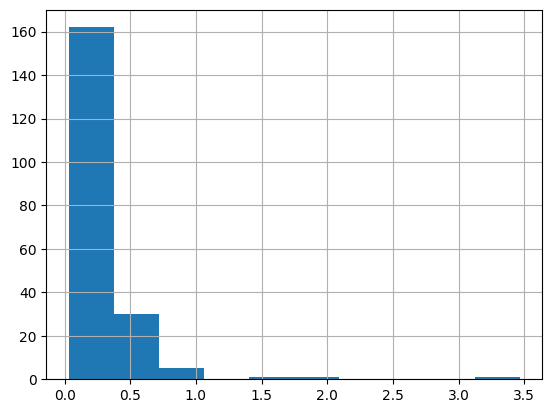

In [12]:
mrks['tf_idf'].hist()

Text(0, 0.5, 'IDF')

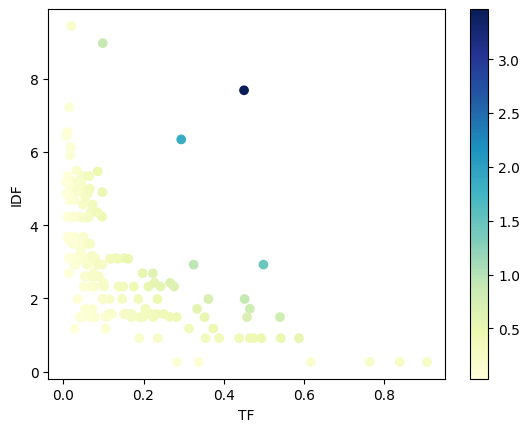

In [13]:
scatter = plt.scatter(mrks['tf'], mrks['idf'], c=mrks['tf_idf'], cmap='YlGnBu')
plt.colorbar(scatter)
plt.xlabel('TF')
plt.ylabel('IDF')

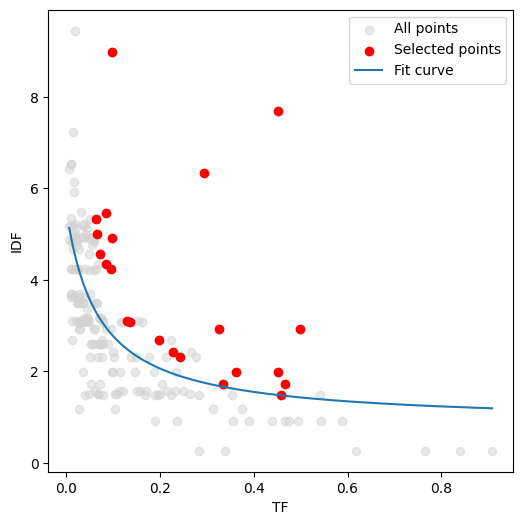

In [14]:
x_col = 'tf'
y_col = 'idf'
df = mrks
tfidf_threshold = 0.3
tf_ratio = 1.2

# Visualization
plt.figure(figsize=(6, 6))

# Plot all points
plt.scatter(df[x_col], df[y_col], alpha=0.5, c='lightgray', label='All points')

# Plot selected points
filtered_mrks, curve = sccellfie.external.filter_tfidf_markers(df, tf_col=x_col, idf_col=y_col, tfidf_threshold=tfidf_threshold, tf_ratio=tf_ratio)

plt.scatter(filtered_mrks[x_col], filtered_mrks[y_col], c='red', label='Selected points')
plt.plot(*curve, label='Fit curve')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.legend()

In [17]:
tf_idf_mrks = filtered_mrks['gene'].unique().tolist()
len(tf_idf_mrks)

19

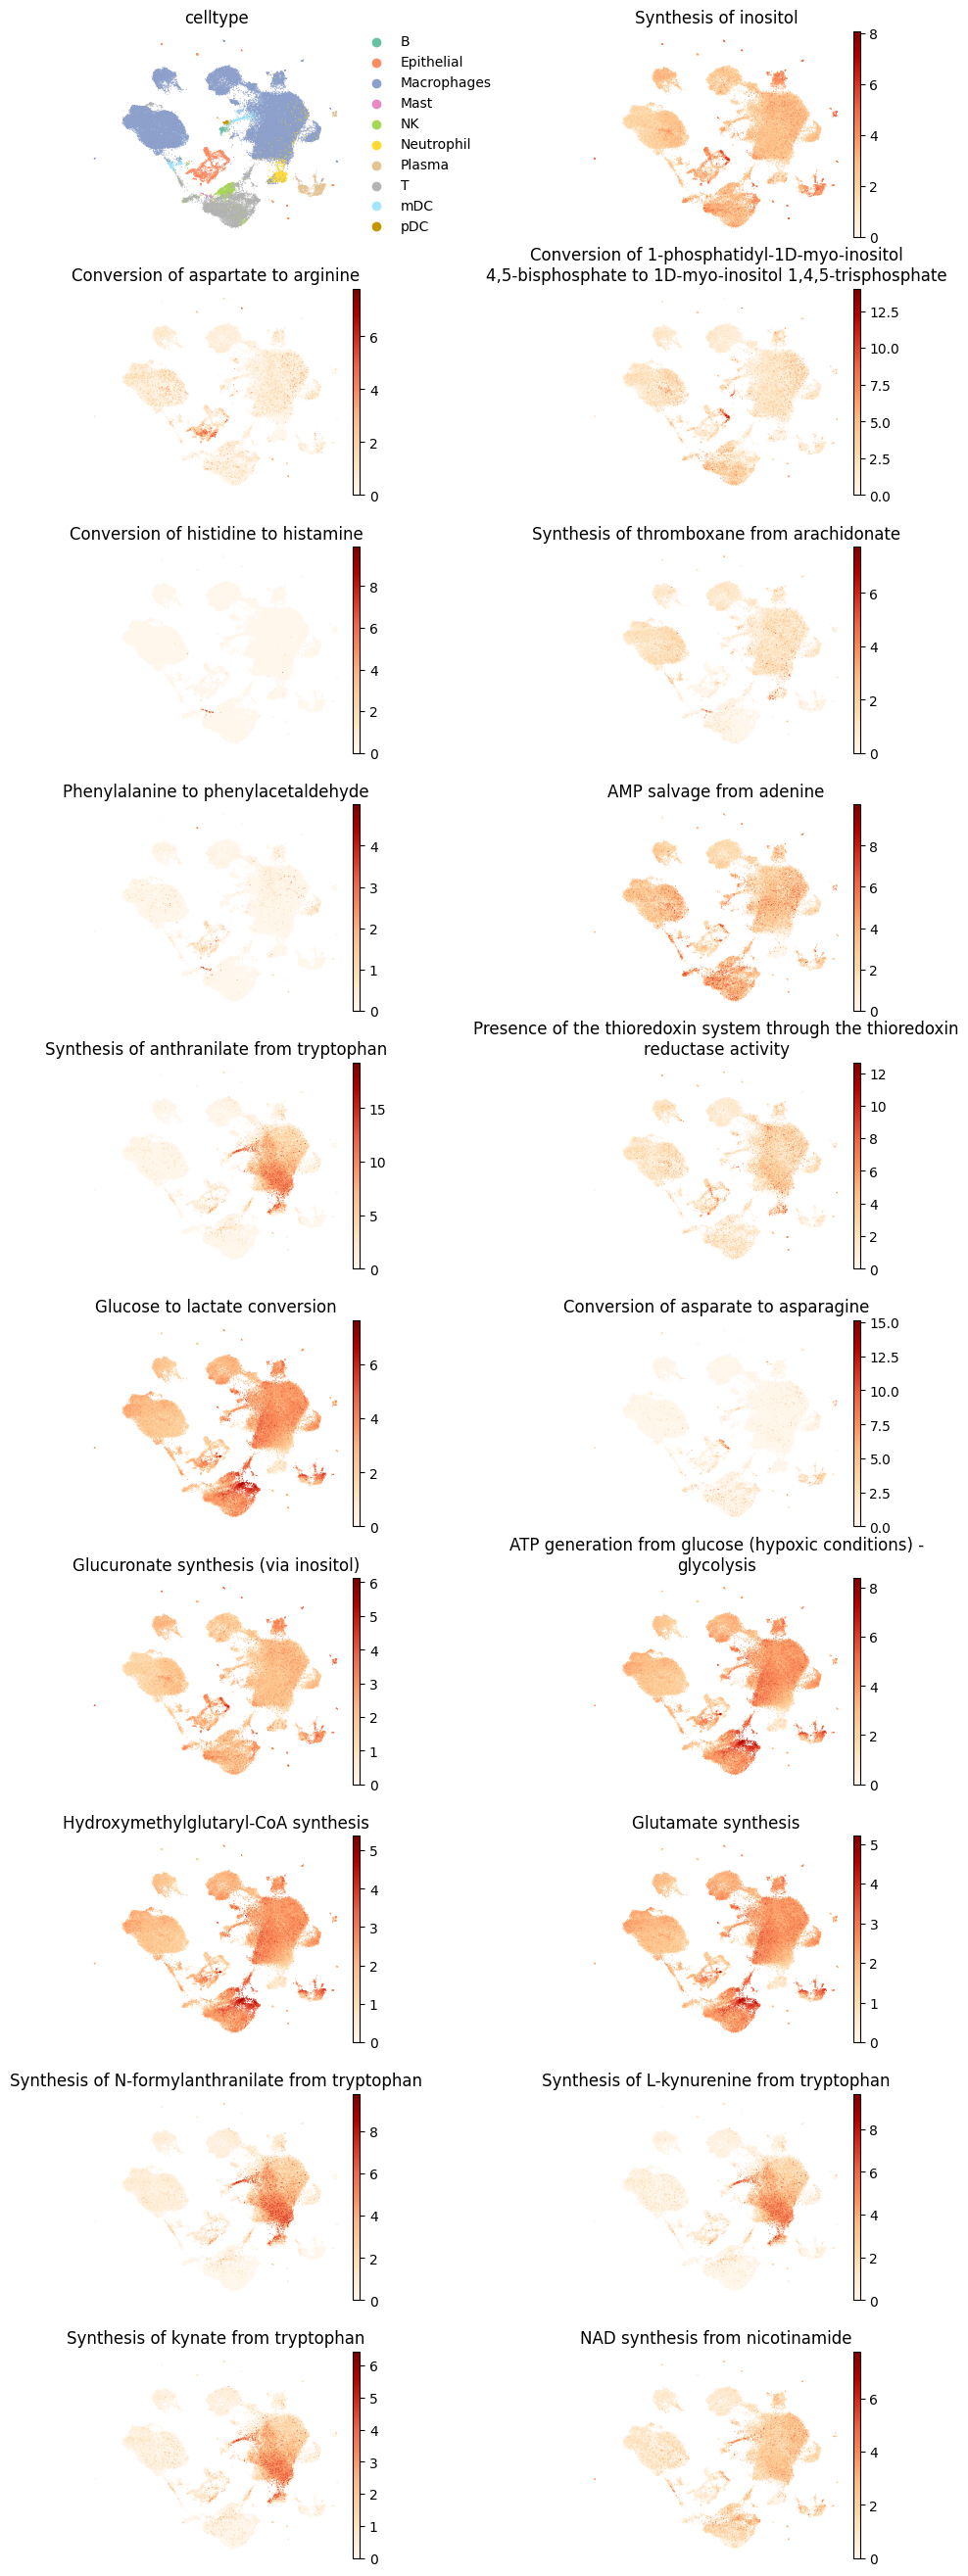

In [21]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + tf_idf_mrks,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + tf_idf_mrks],
                cmap='OrRd'
               )

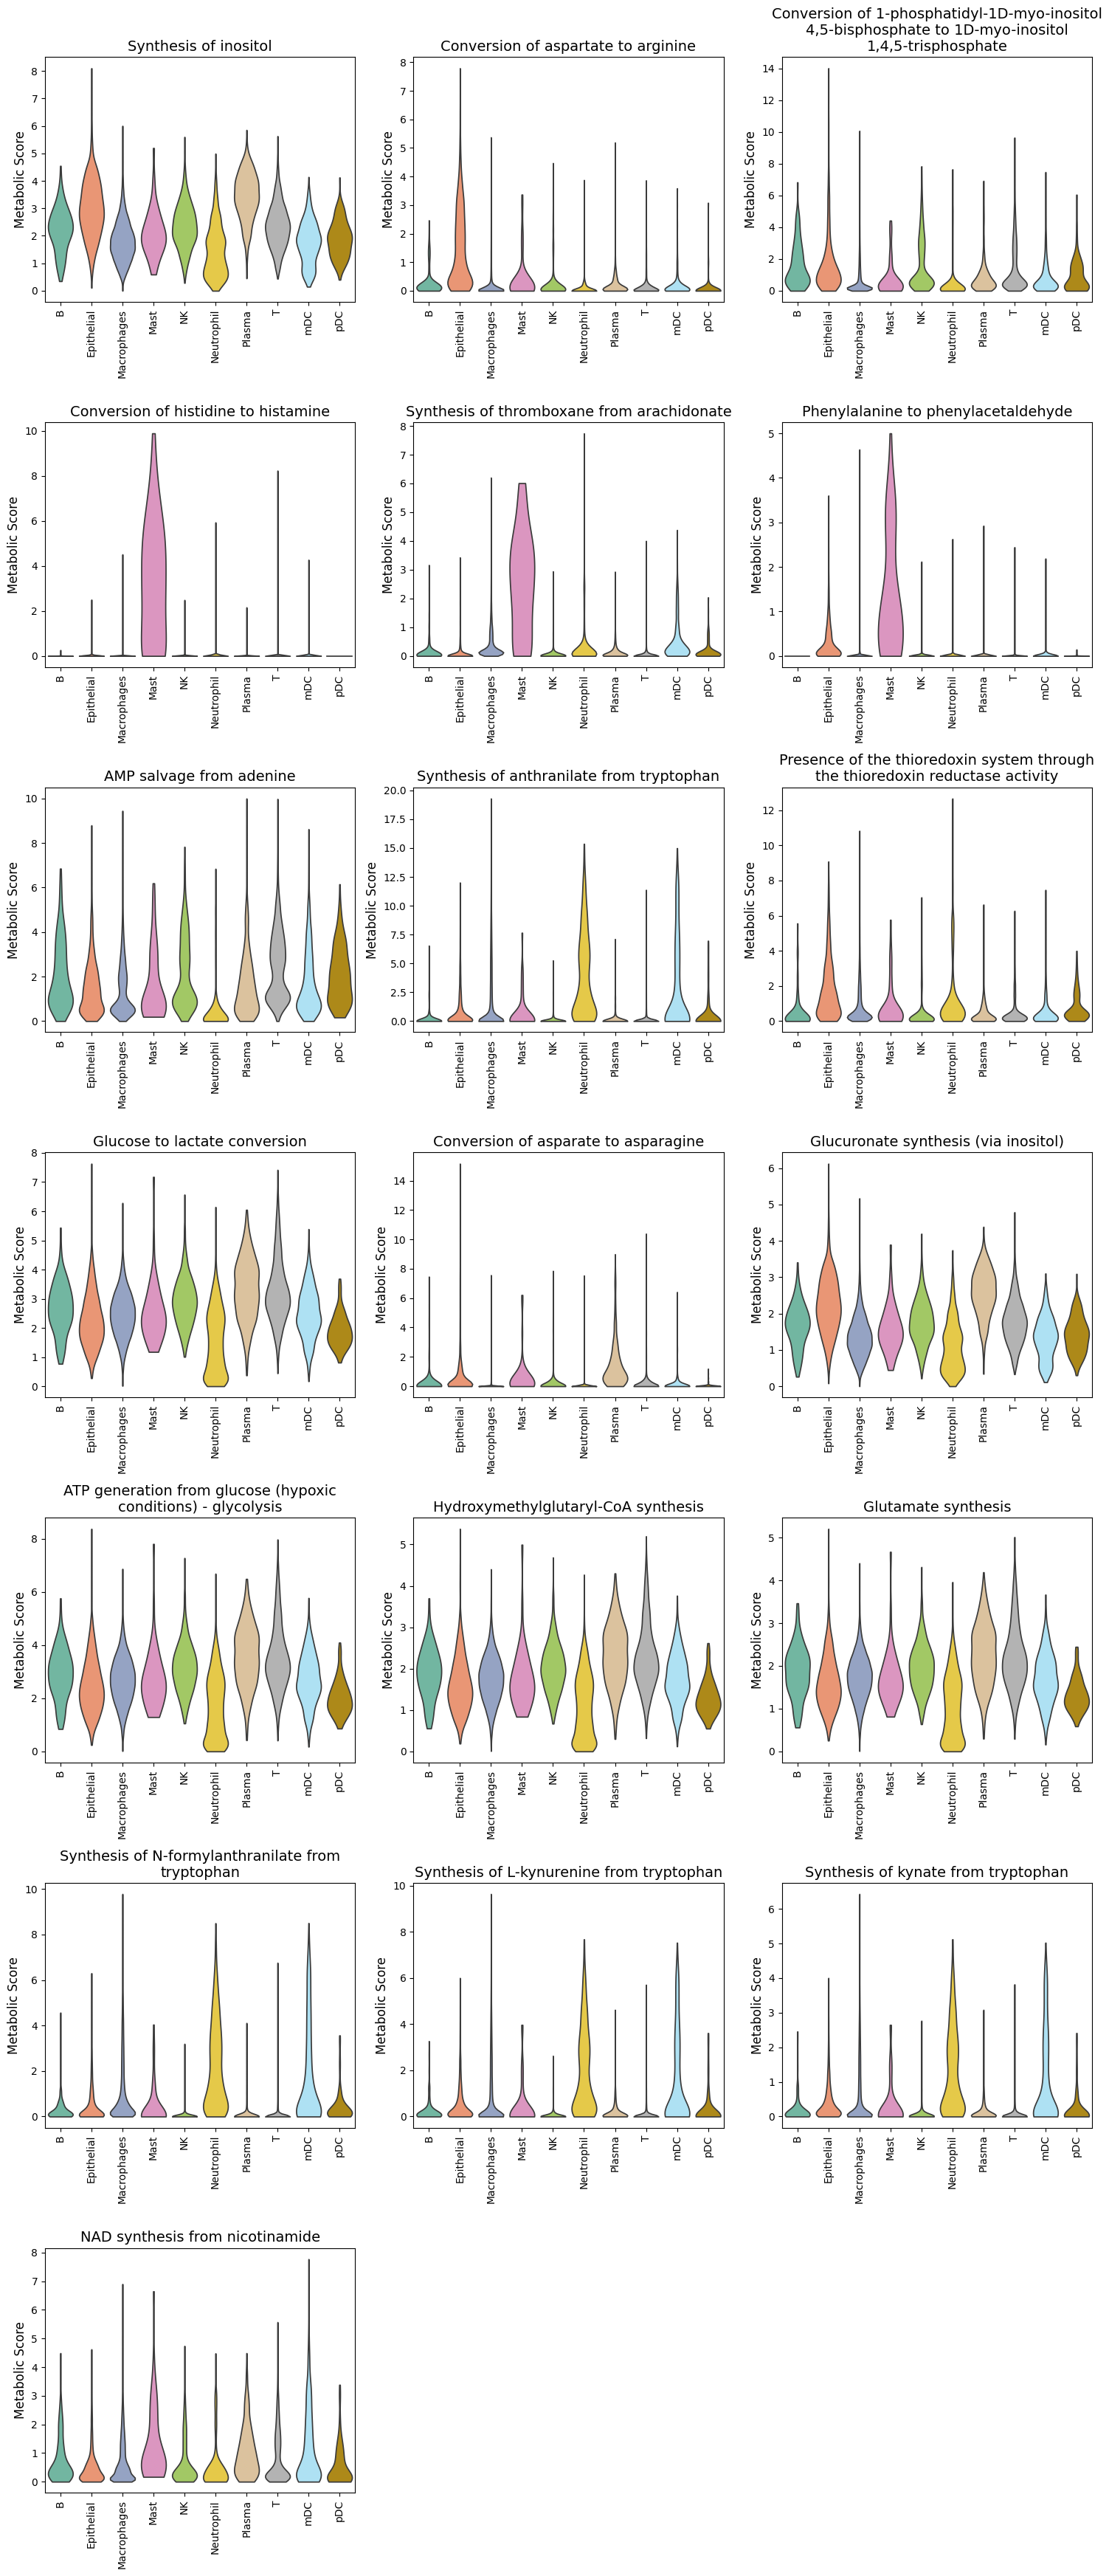

In [22]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=tf_idf_mrks,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=3,
                                                         ylabel='Metabolic Score'
                                                        )

### Detection using Logistic Regression in Scanpy

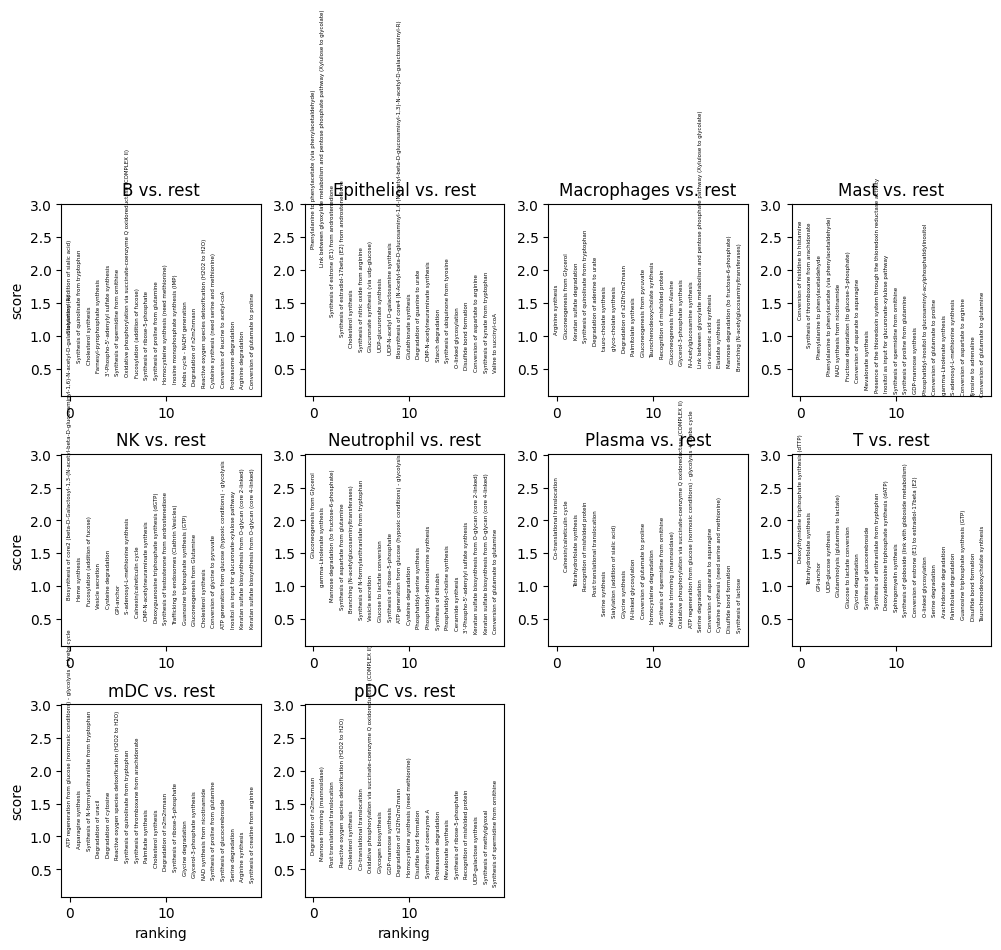

In [23]:
method = 'logreg'
sc.tl.rank_genes_groups(results['adata'].metabolic_tasks, cell_group, method=method,
                        use_raw=False, key_added = method)

sc.pl.rank_genes_groups(results['adata'].metabolic_tasks, n_genes=20, sharey=True, key=method, fontsize=4)

In [24]:
scanpy_df = sc.get.rank_genes_groups_df(results['adata'].metabolic_tasks,  
                                          key=method, 
                                          group=None) 

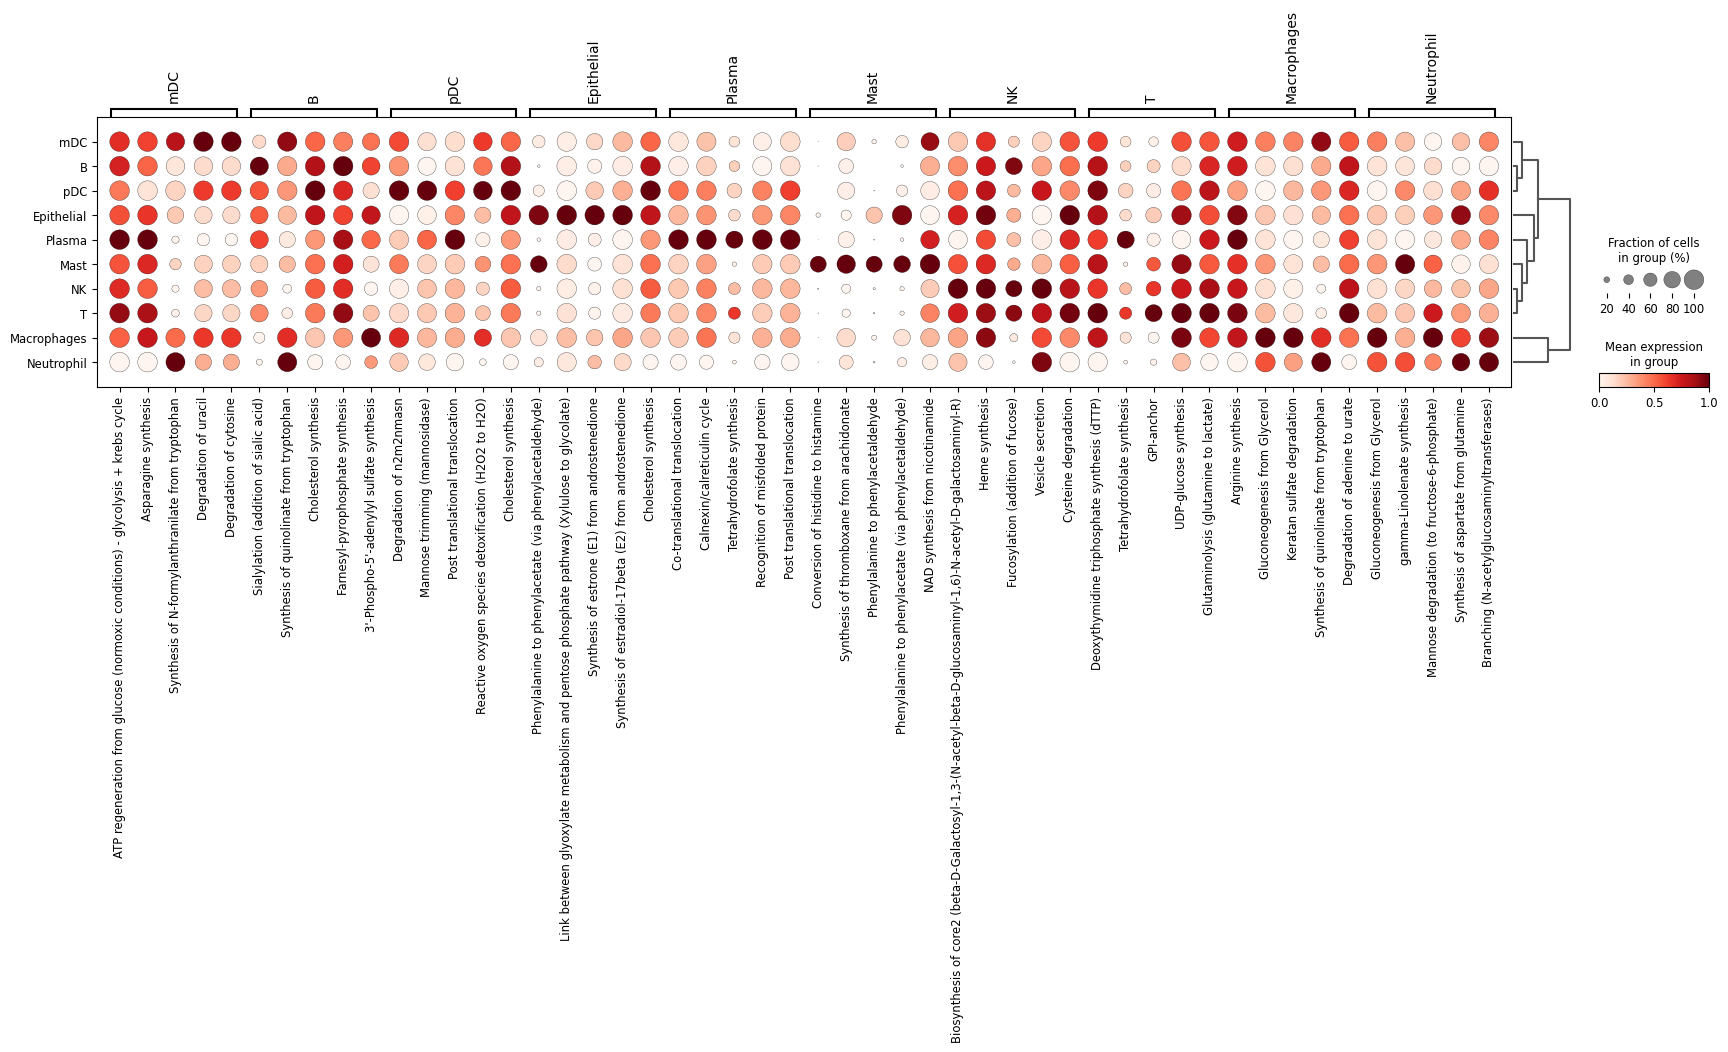

In [26]:
sc.pl.rank_genes_groups_dotplot(results['adata'].metabolic_tasks, n_genes=5, groupby=cell_group, 
                                key=method, use_raw=False, standard_scale='var',
                               )

<Axes: >

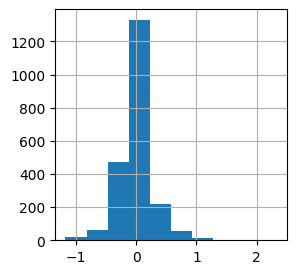

In [27]:
scanpy_df['scores'].hist()

In [28]:
scores_threshold = 1.0

sc_markers_df = scanpy_df
scanpy_markers = sc_markers_df.loc[sc_markers_df['scores'] > scores_threshold]['names'].unique().tolist()
len(scanpy_markers)

11

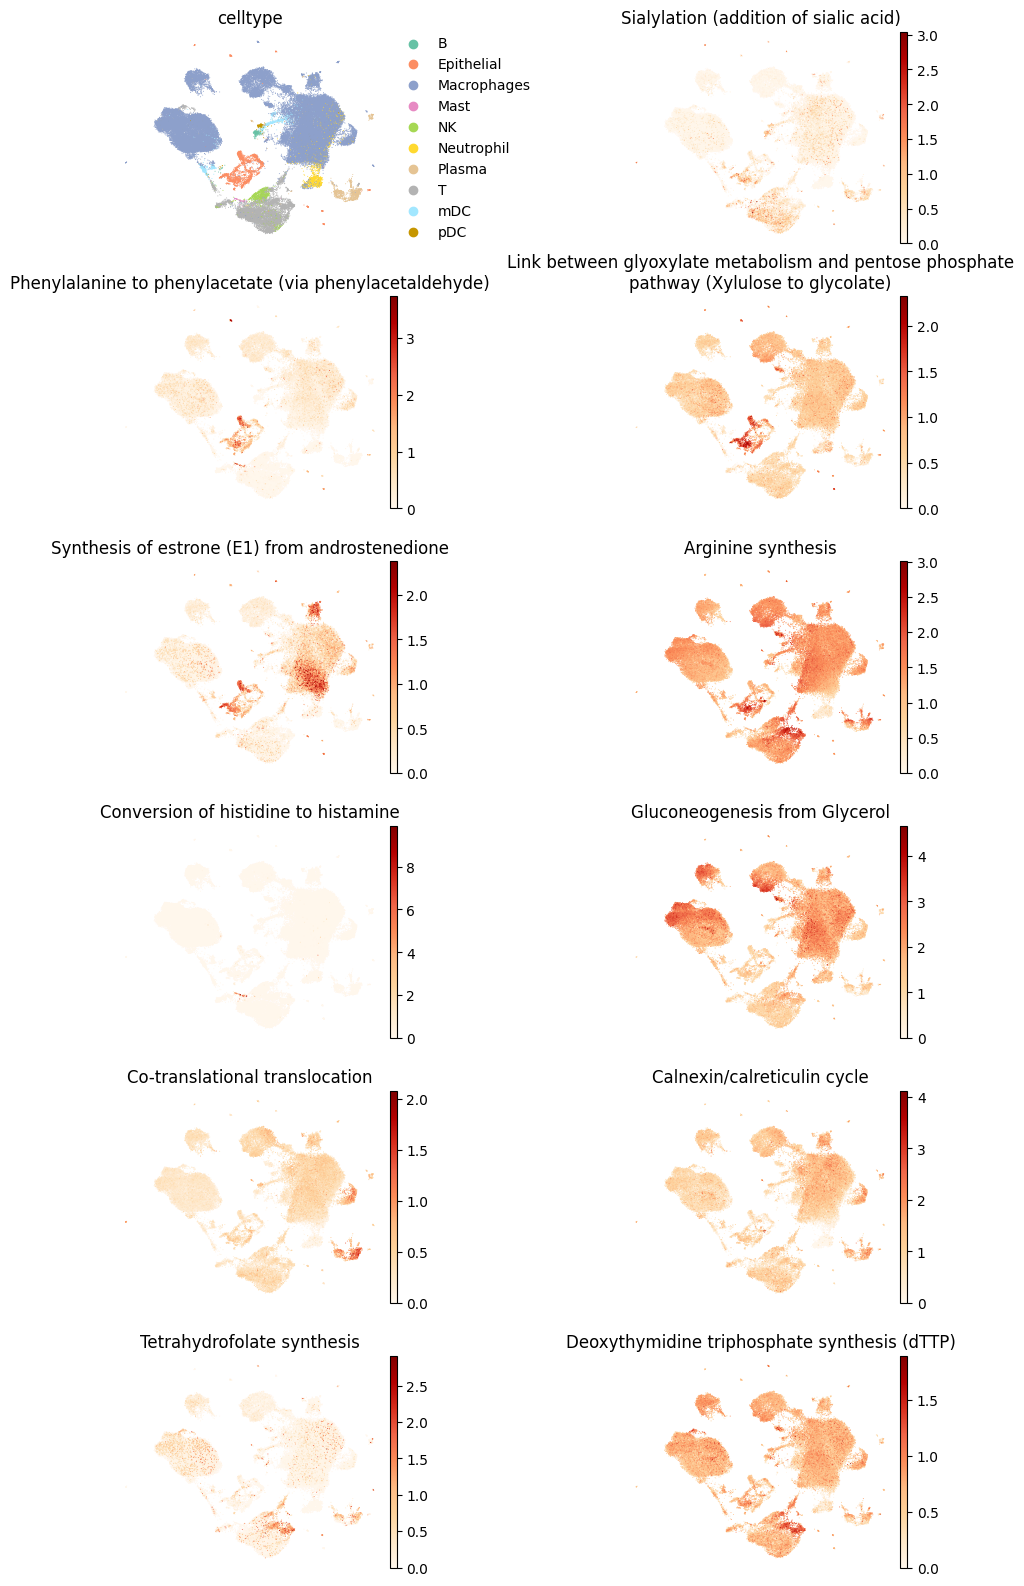

In [31]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + scanpy_markers,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + scanpy_markers],
               )

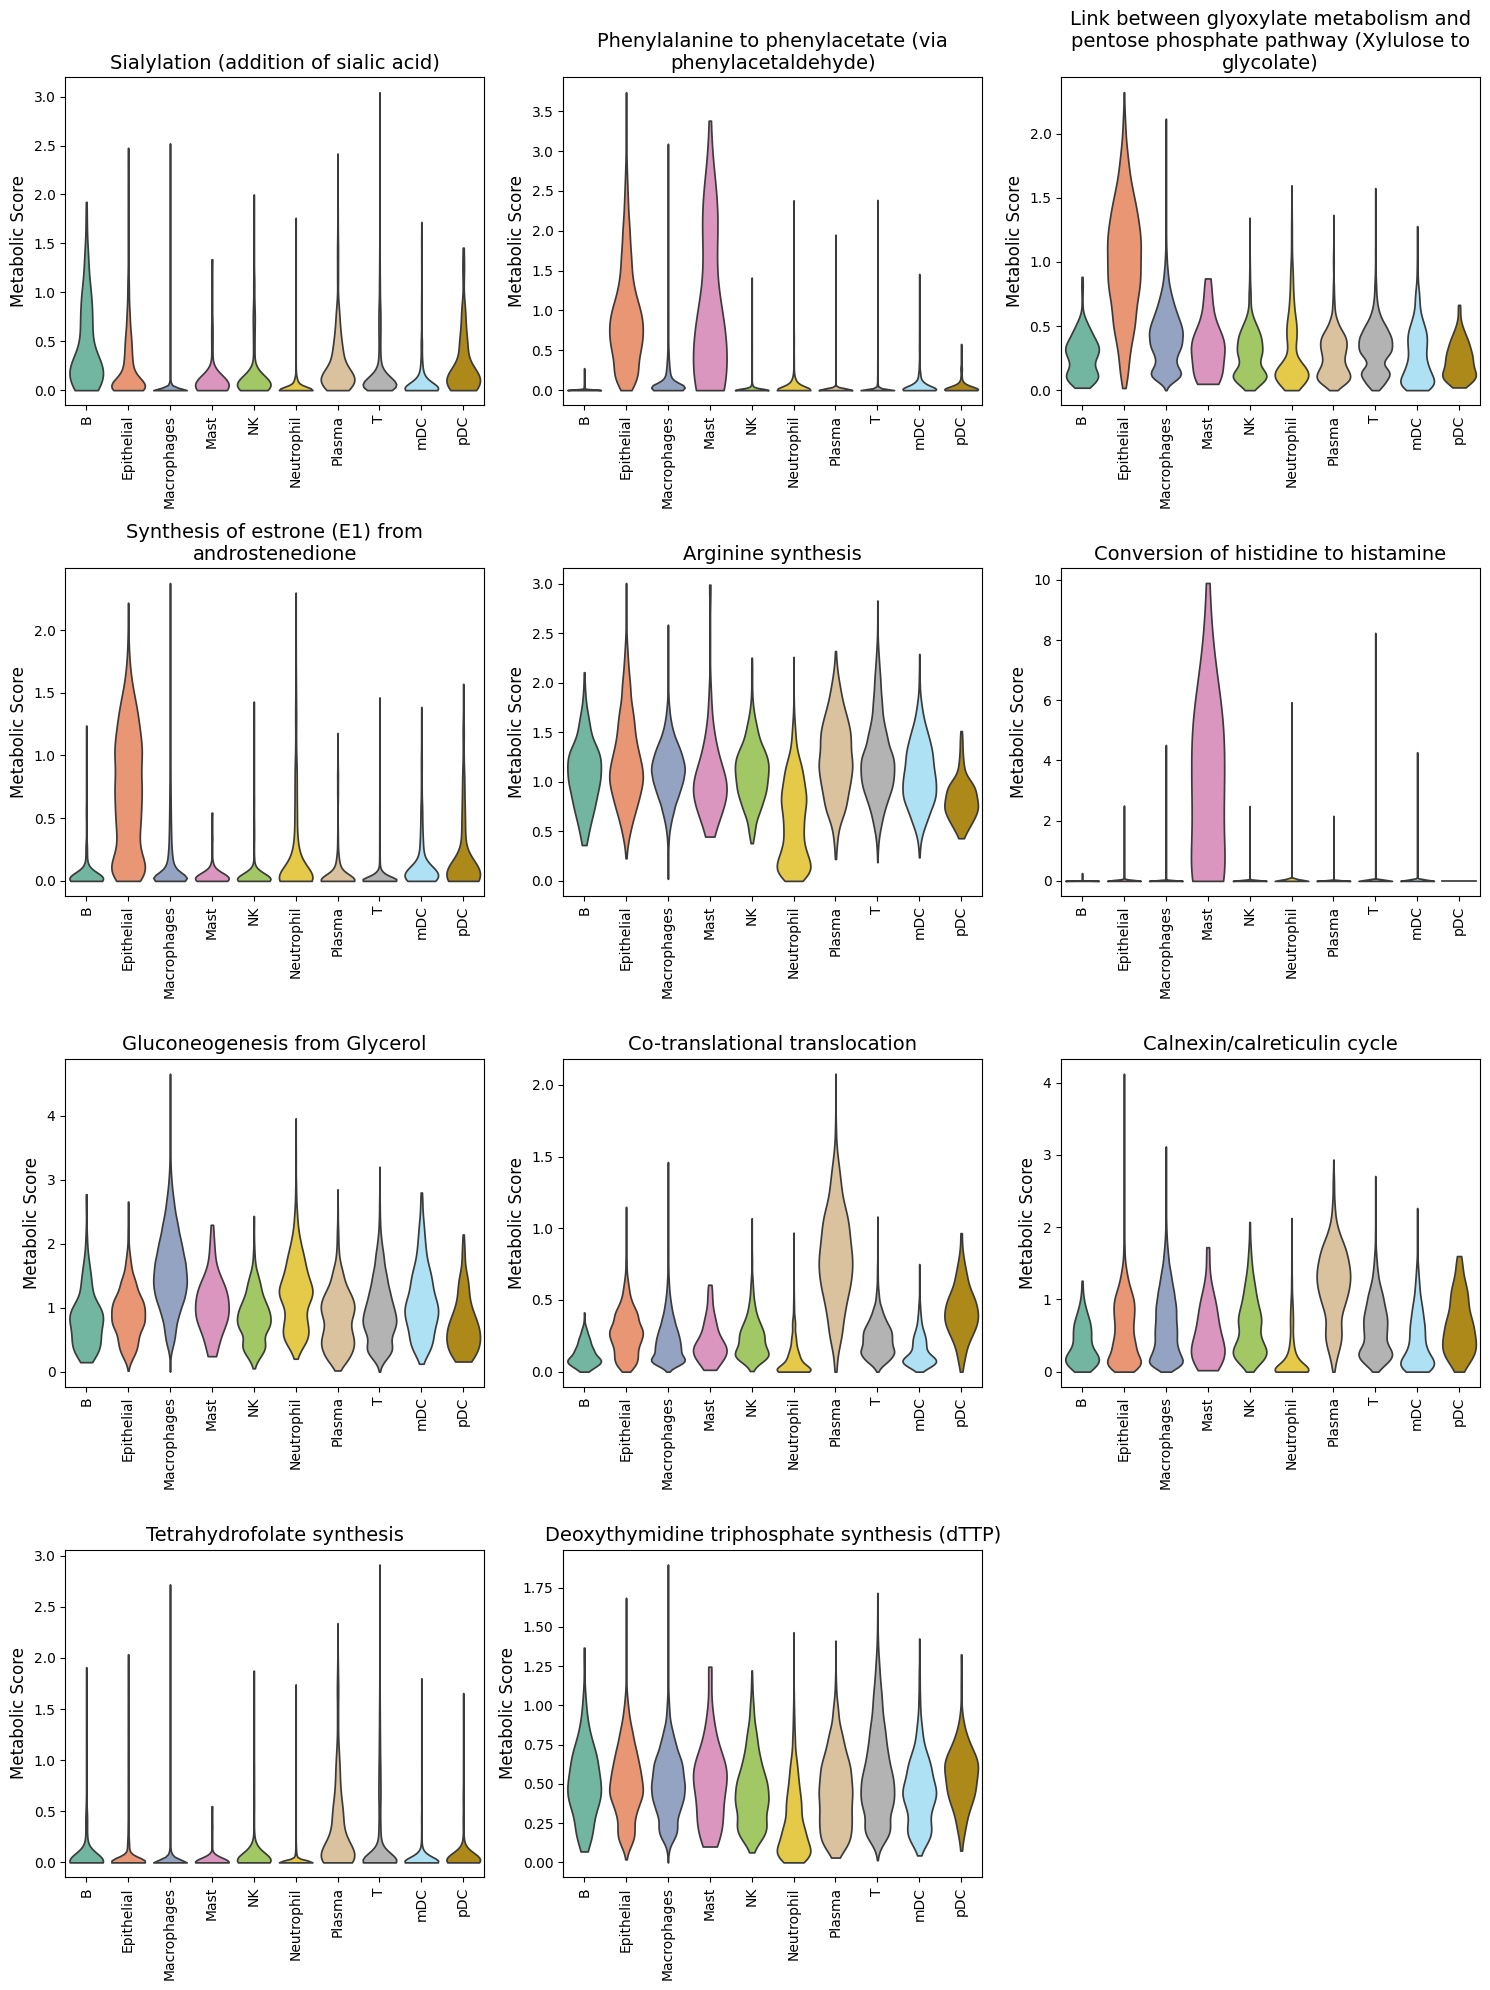

In [32]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=scanpy_markers,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=3,
                                                         ylabel='Metabolic Score'
                                                        )

### Visualize Markers from both methods

In [33]:
both_markers = sorted(set(tf_idf_mrks + scanpy_markers))
len(both_markers)

29

#### Select only highly active markers

In [34]:
agg = sccellfie.expression.aggregation.agg_expression_cells(results['adata'].metabolic_tasks[:, both_markers],
                                                            groupby=cell_group, 
                                                            agg_func='trimean')

In [35]:
both_markers = agg.T.loc[(agg.T > 1.).any(axis=1)].index.tolist()
len(both_markers)

23

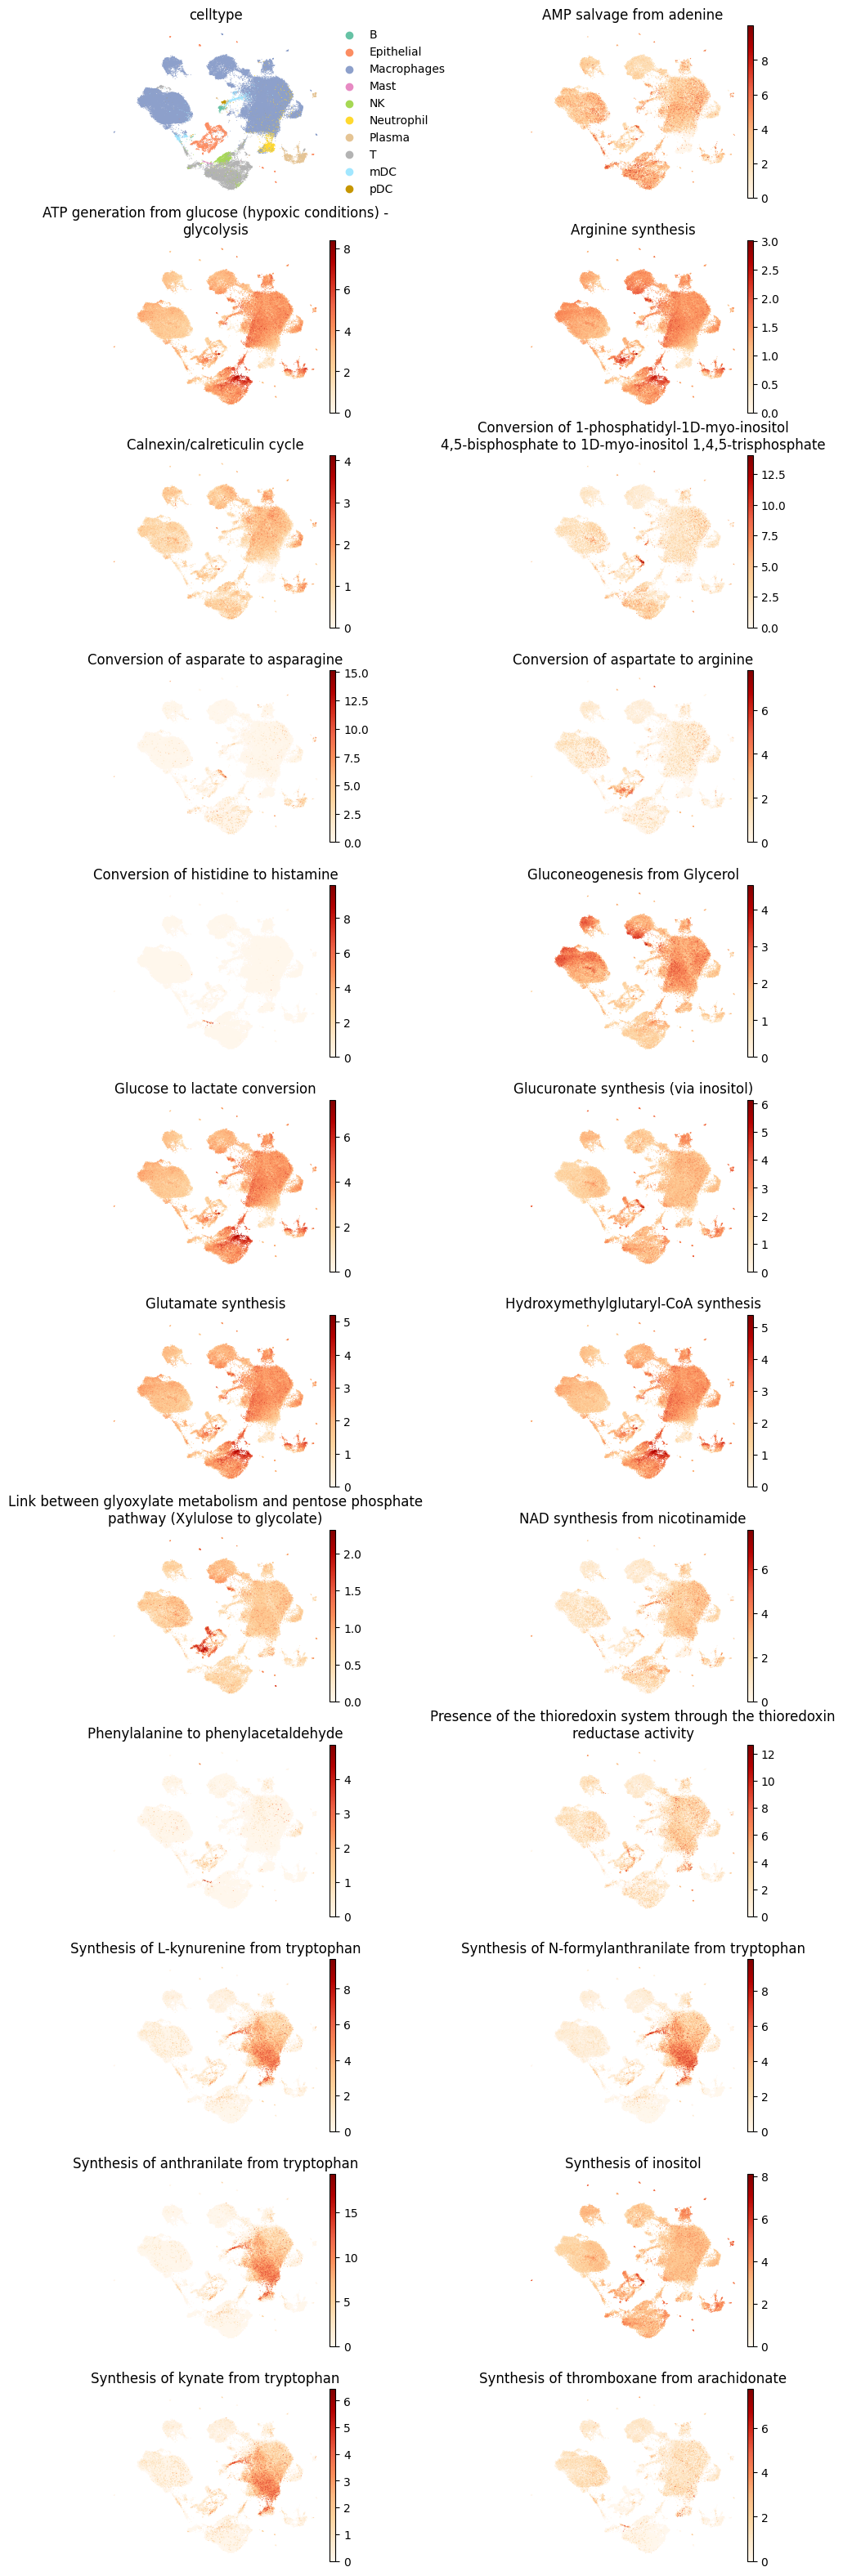

In [38]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + both_markers,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + both_markers],
               )

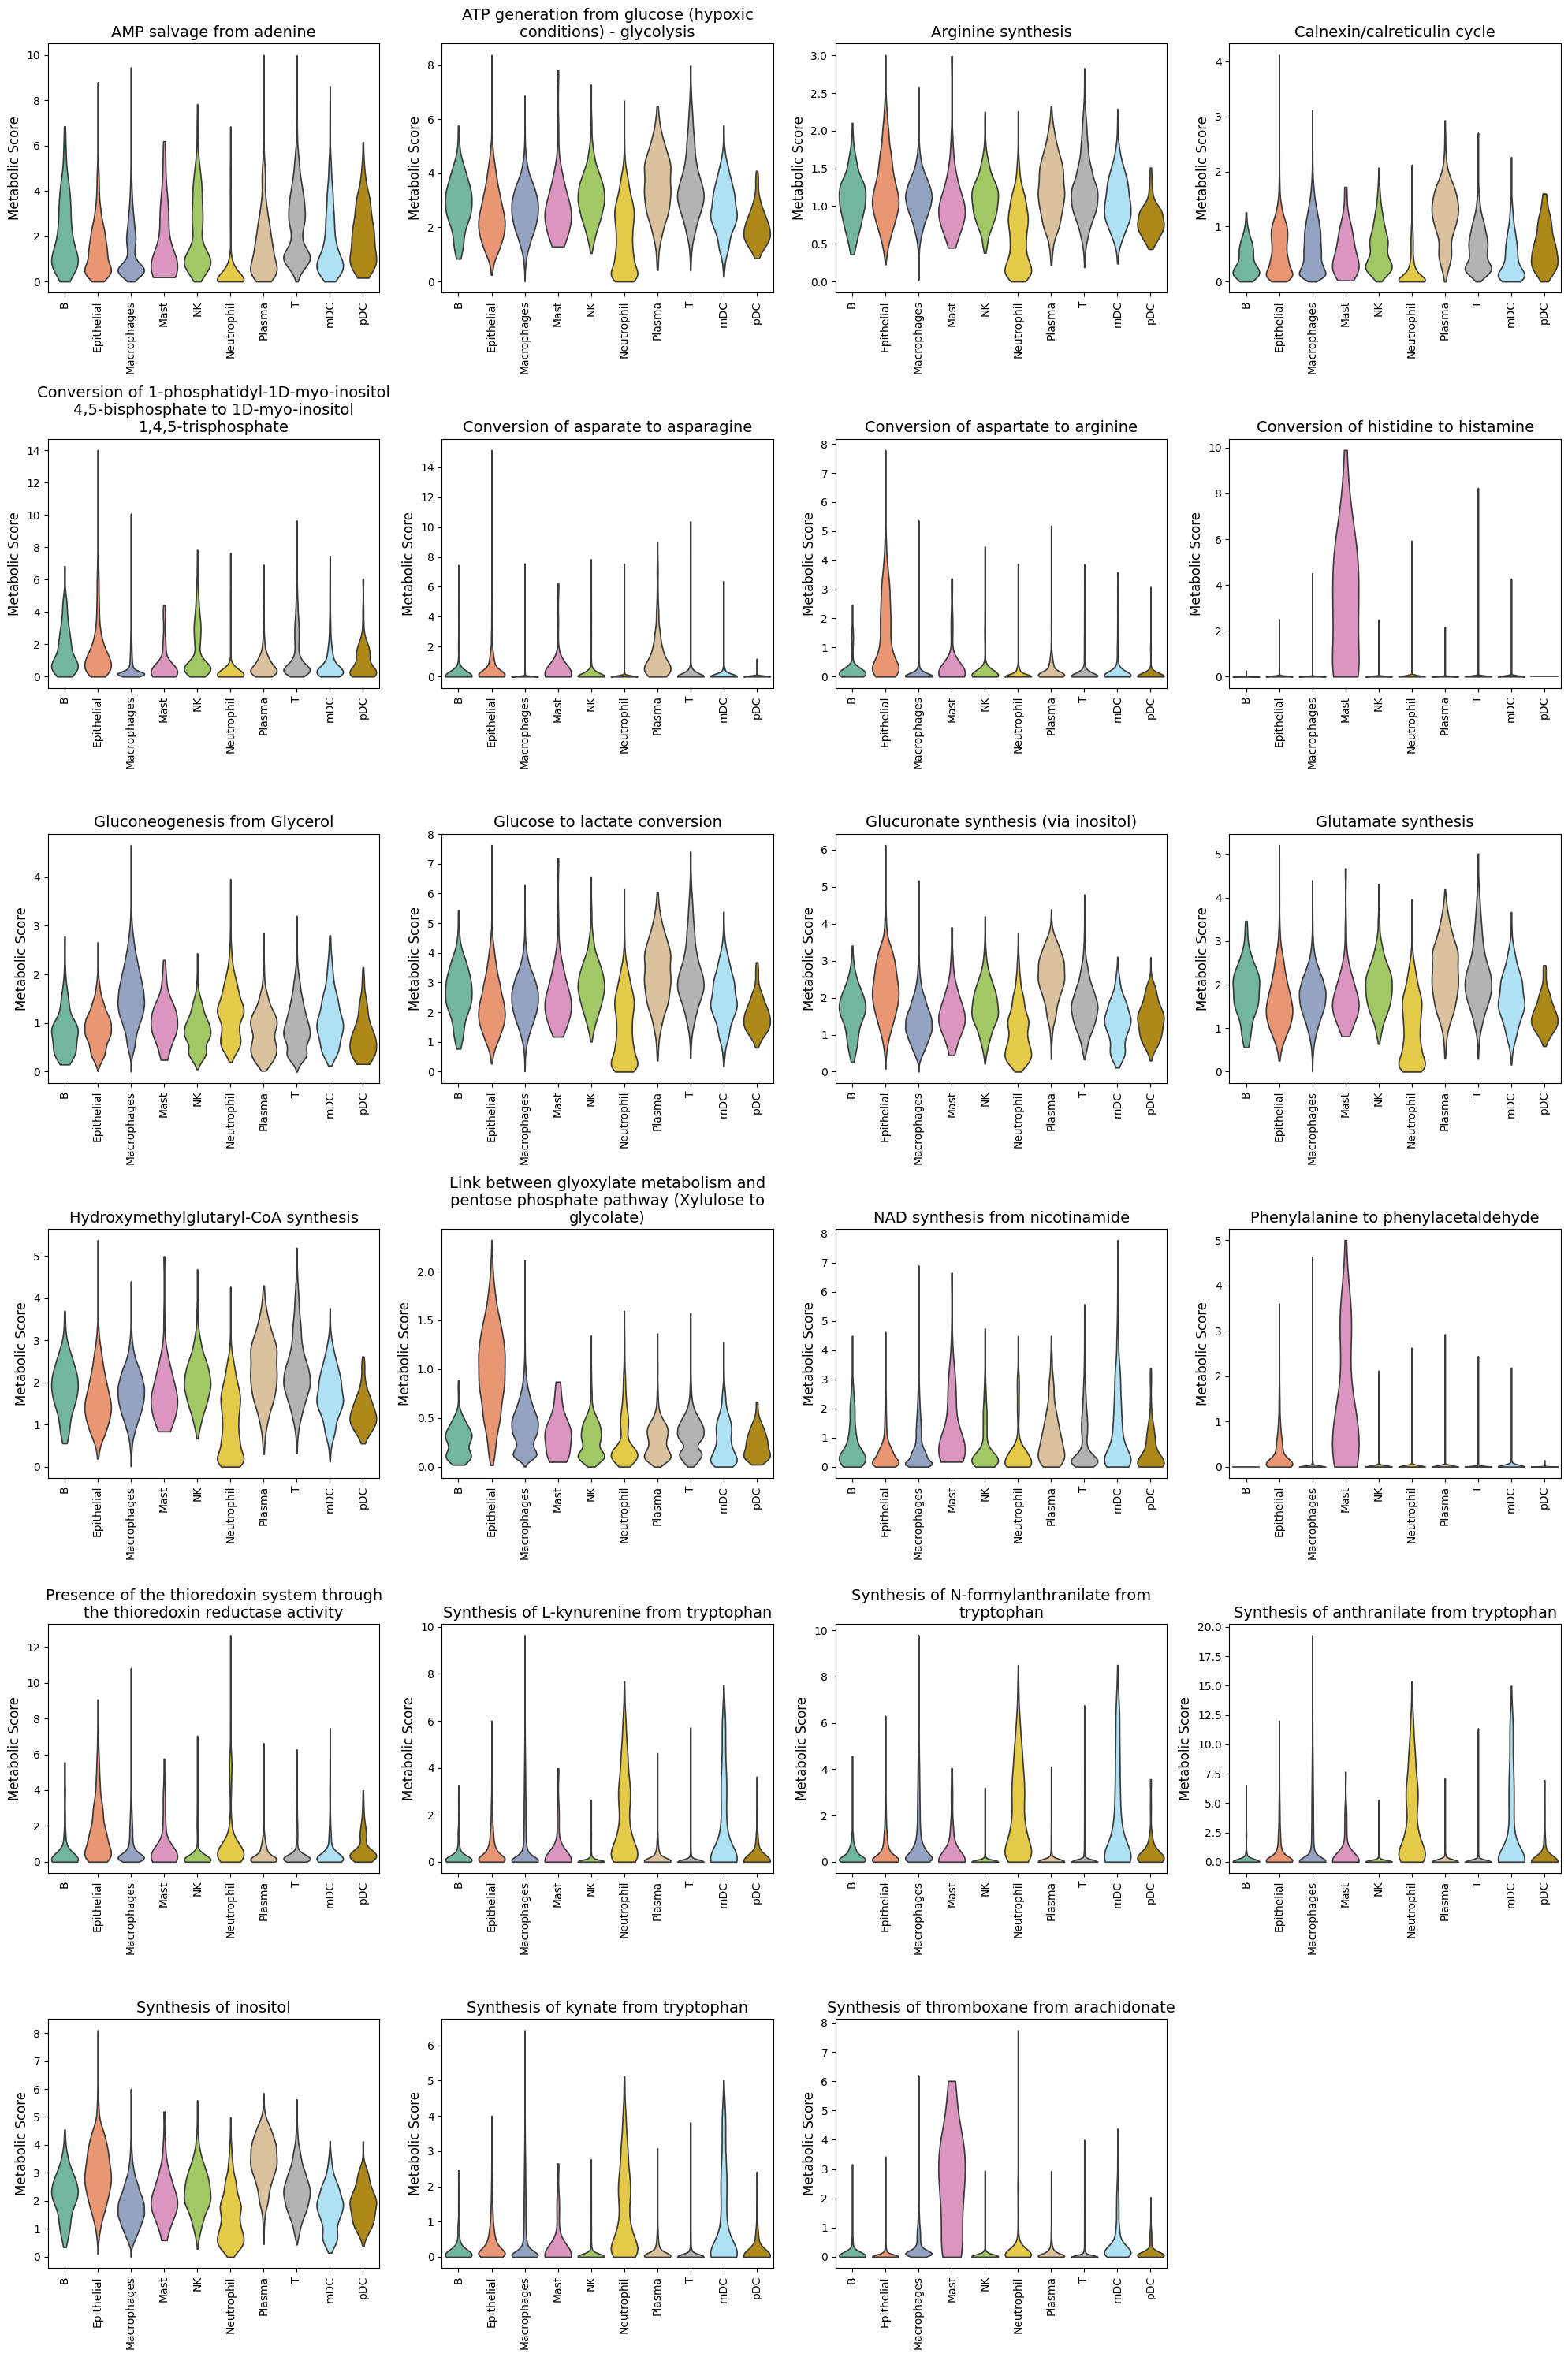

In [37]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=both_markers,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=4,
                                                         ylabel='Metabolic Score'
                                                        )

## Differential metabolic analysis between conditions, per cell type

### Select conditions to compare

In [39]:
adata.obs.condition.unique()

['Control', 'Moderate COVID-19', 'Severe COVID-19']
Categories (3, object): ['Control', 'Moderate COVID-19', 'Severe COVID-19']

In [40]:
contrasts = [('Control', 'Severe COVID-19')]
condition_key = 'condition'

### Perform differential analysis

In [41]:
dma = sccellfie.stats.scanpy_differential_analysis(results['adata'].metabolic_tasks,
                                                   cell_type=None, 
                                                   cell_type_key=cell_group, 
                                                   condition_key=condition_key,
                                                   min_cells=20,
                                                   condition_pairs=contrasts)

Processing DE analysis: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Excluded comparisons due to insufficient cells:

pDC:
  - Control vs Severe COVID-19 (n1=12, n2=76)

Plasma:
  - Control vs Severe COVID-19 (n1=3, n2=1024)

Mast:
  - Control vs Severe COVID-19 (n1=6, n2=39)

Neutrophil:
  - Control vs Severe COVID-19 (n1=0, n2=1603)


### Identify significant changes per cell type

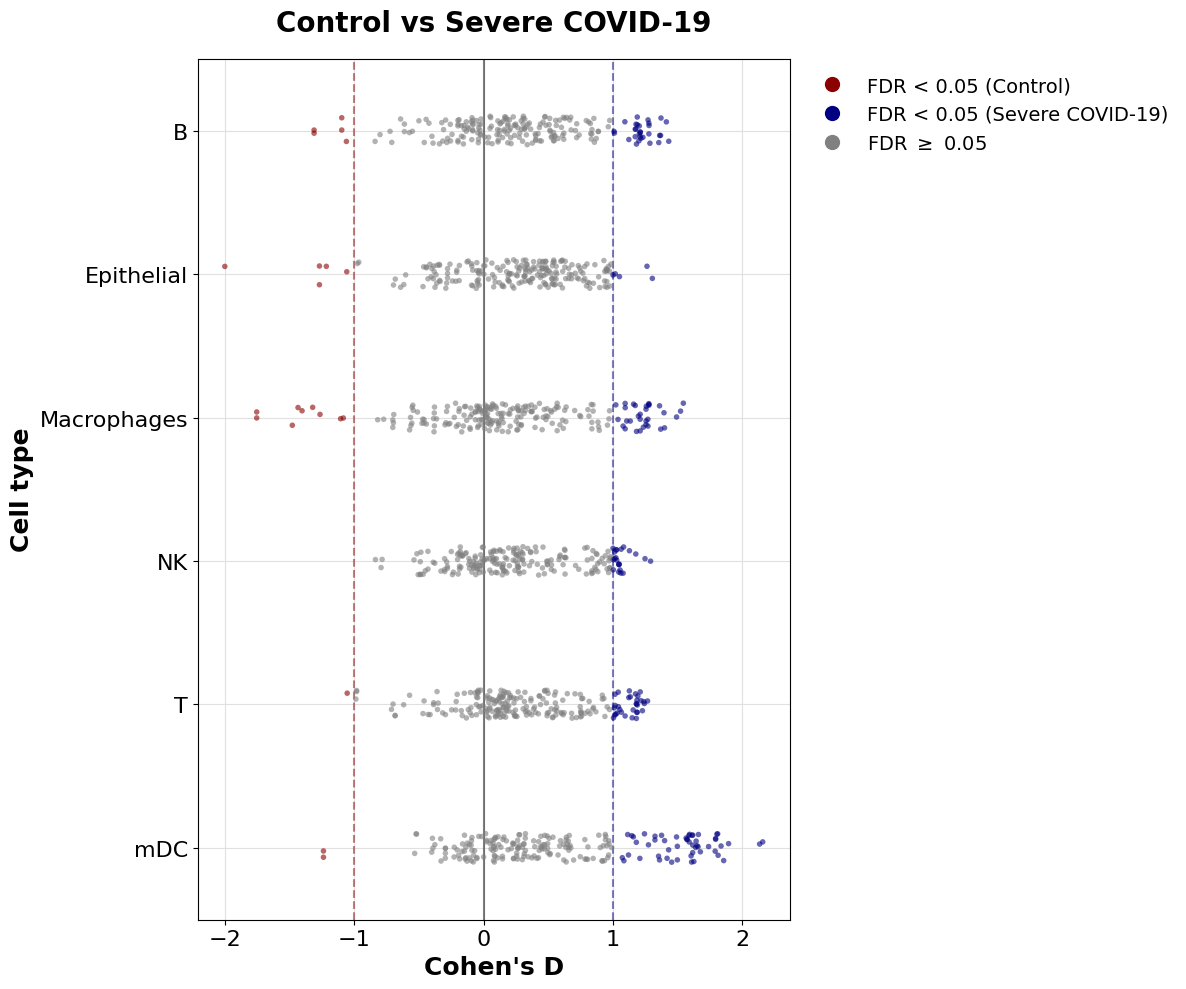

In [44]:
cohen_threshold = 1.0
pval_threshold = 0.05
logfc_threshold = 0.0

fig, ax, sig = sccellfie.plotting.create_beeswarm_plot(dma,
                                                       x='cohens_d', 
                                                       cohen_threshold=cohen_threshold, 
                                                       pval_threshold=pval_threshold,
                                                       logfc_threshold=logfc_threshold,
                                                       show_n_significant=False,
                                                       strip_jitter=True,
                                                       lgd_bbox_to_anchor=(1.01, 1),
                                                       ticks_fontsize=16,
                                                       labels_fontsize=18,
                                                       figsize=(12, 10),
                                                       #save=scCellFie-Diff-Analysis.pdf
                                                      )

In [45]:
sig_tasks = sig.reset_index().feature.unique().tolist()
len(sig_tasks)

76

### Plot number of major task groups up/down regulated

In [46]:
sccellfie_db = results

In [47]:
def plot_single(condition, ax, pathway, sig_data):
    pathway_counts = {'System': pd.DataFrame(), 'Subsystem': pd.DataFrame()}

    for c, df in sig_data.reset_index().groupby('cell_type'):
        for k, v in pathway_counts.items():
            df2 = df.set_index('feature').join(sccellfie_db['task_info'].set_index('Task'), how='inner')
            df2 = df2.loc[df2.log2FC > 0] if condition == 'up' else df2.loc[df2.log2FC < 0]
            df2 = df2.value_counts(k).to_frame().reset_index()
            df2['cell_type'] = c
            df2 = df2[['cell_type', k, 'count']]
            df2[k] = df2[k].apply(lambda x: x.upper())
            pathway_counts[k] = pd.concat([pathway_counts[k], df2])

    df = pathway_counts[pathway].sort_values('count')
    totals = df.groupby('cell_type')['count'].sum()

    df_normalized = df.copy()
    df_normalized['fraction'] = df.groupby('cell_type')['count'].transform(lambda x: x / x.sum())
    pivoted_data = df_normalized.pivot(index='cell_type', columns=pathway, values='fraction')
    pivoted_data = pivoted_data.sort_index().fillna(0.)

    n_systems = len(pivoted_data.columns)
    colors = glasbey.extend_palette('Set2', palette_size=max([n_systems, 10]))

    pivoted_data.plot(kind='barh', stacked=True, ax=ax, color=colors, legend=False)
    ax.set_xlim((0, 1))
    ax.invert_yaxis()

    ylabels = ax.get_yticklabels()
    ax.tick_params(axis='both', which='major', labelsize=12)

    for idx, cell_type in enumerate(pivoted_data.index):
        ax.text(1.02, idx, f'n={totals[cell_type]:,}', va='center', fontsize=12)

    ax.set_xlabel('Fraction', fontsize=14)
    ax.set_ylabel('')

    return pivoted_data.columns, colors

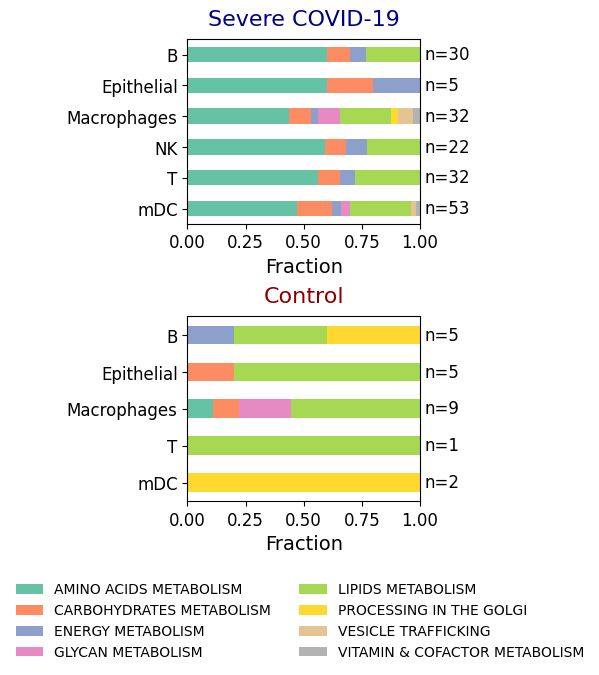

In [48]:
from matplotlib.colors import to_rgb

pathway = 'System'
condition1_color='#8B0000'
condition2_color='#000080'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 6), height_ratios=[1, 1])

legend_elements, colors = plot_single('up', ax1, pathway, sig)
plot_single('down', ax2, pathway, sig)

ax1.set_title('Severe COVID-19', fontsize=16, pad=10, color=to_rgb(condition2_color))
ax2.set_title('Control', fontsize=16, pad=10, color=to_rgb(condition1_color))

plt.figlegend(labels=legend_elements, 
              bbox_to_anchor=(0.5, -0.005),
              ncols=2 if pathway == 'System' else 2,
              frameon=False,
              loc='upper center')

plt.subplots_adjust(hspace=0.5)
# plt.savefig(f'./scCellFie-DA-{pathway}-Combined.pdf', 
#             dpi=300, 
#             bbox_inches='tight')

### Visualize changes in distributions across single cells

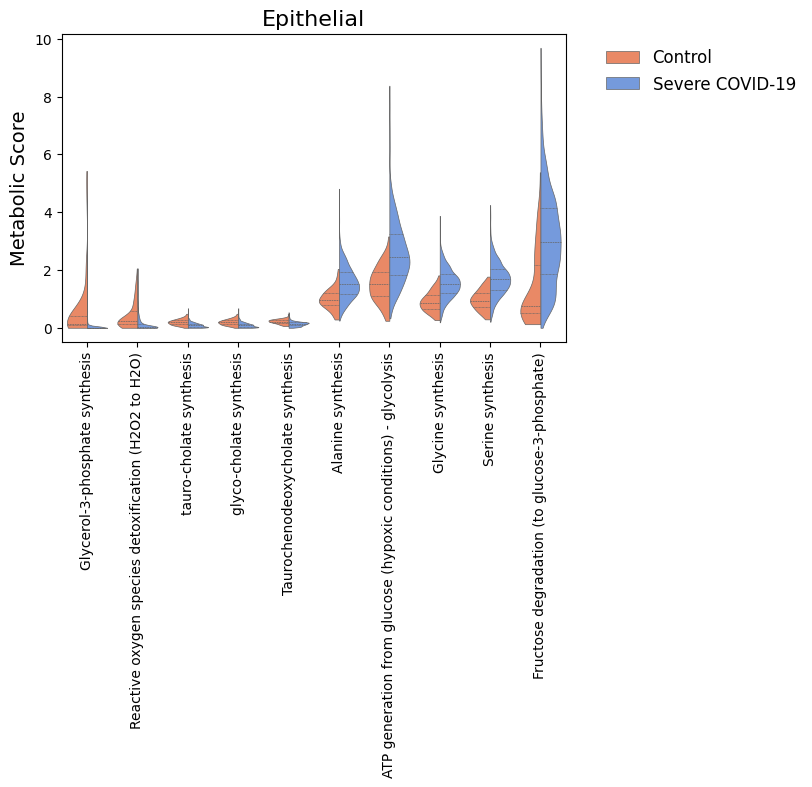

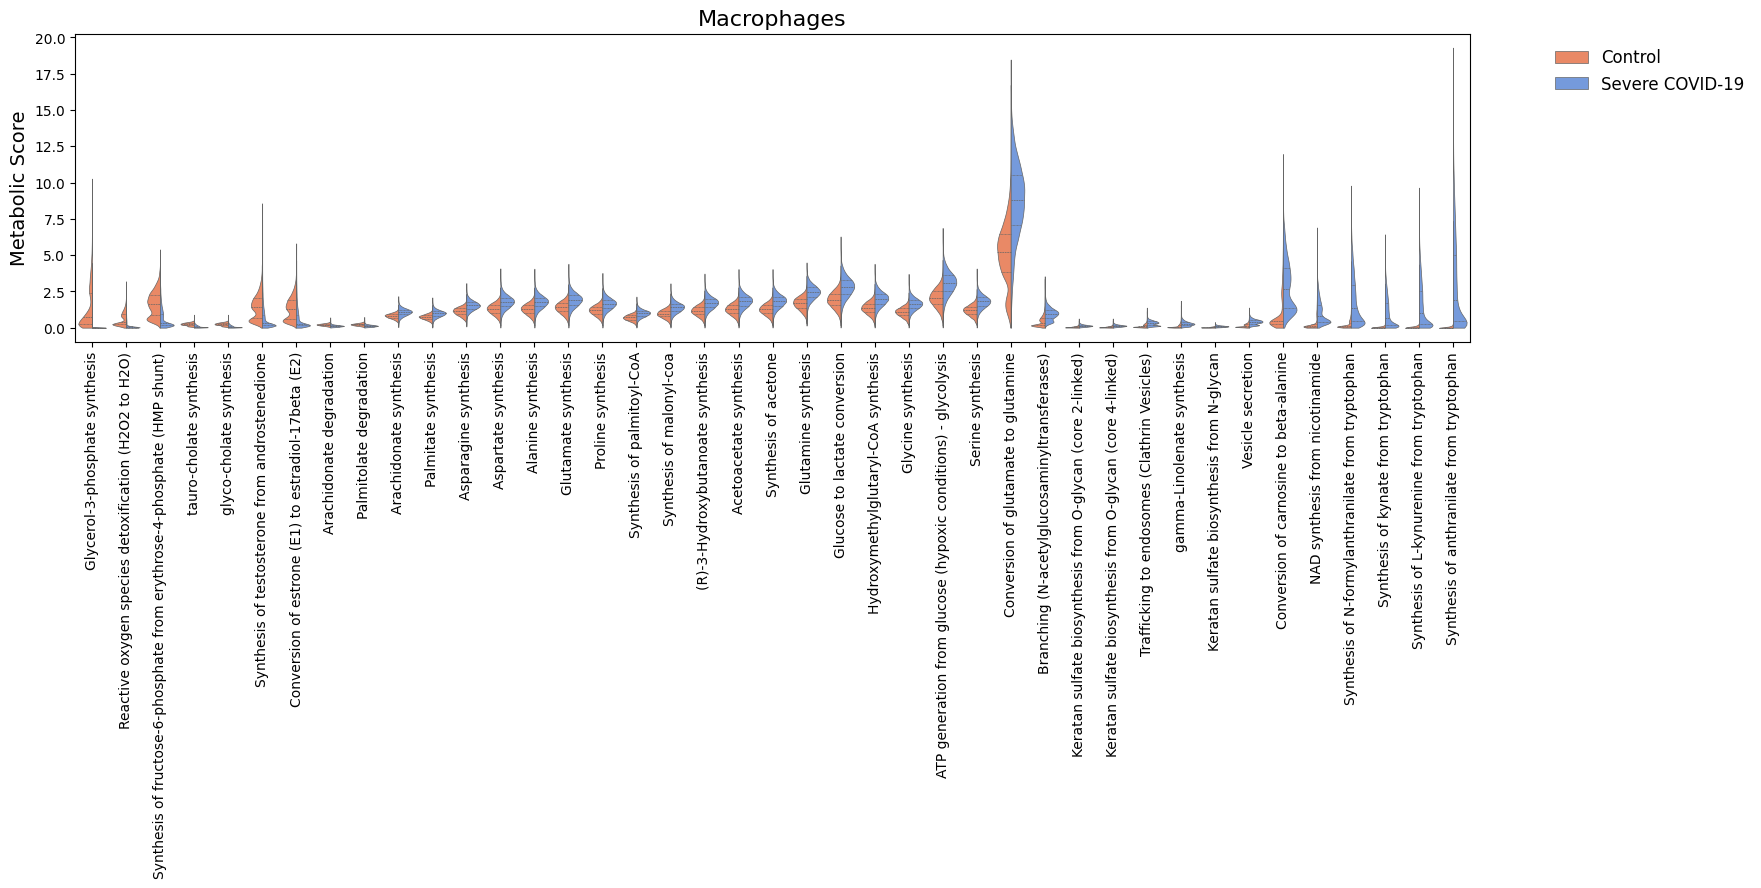

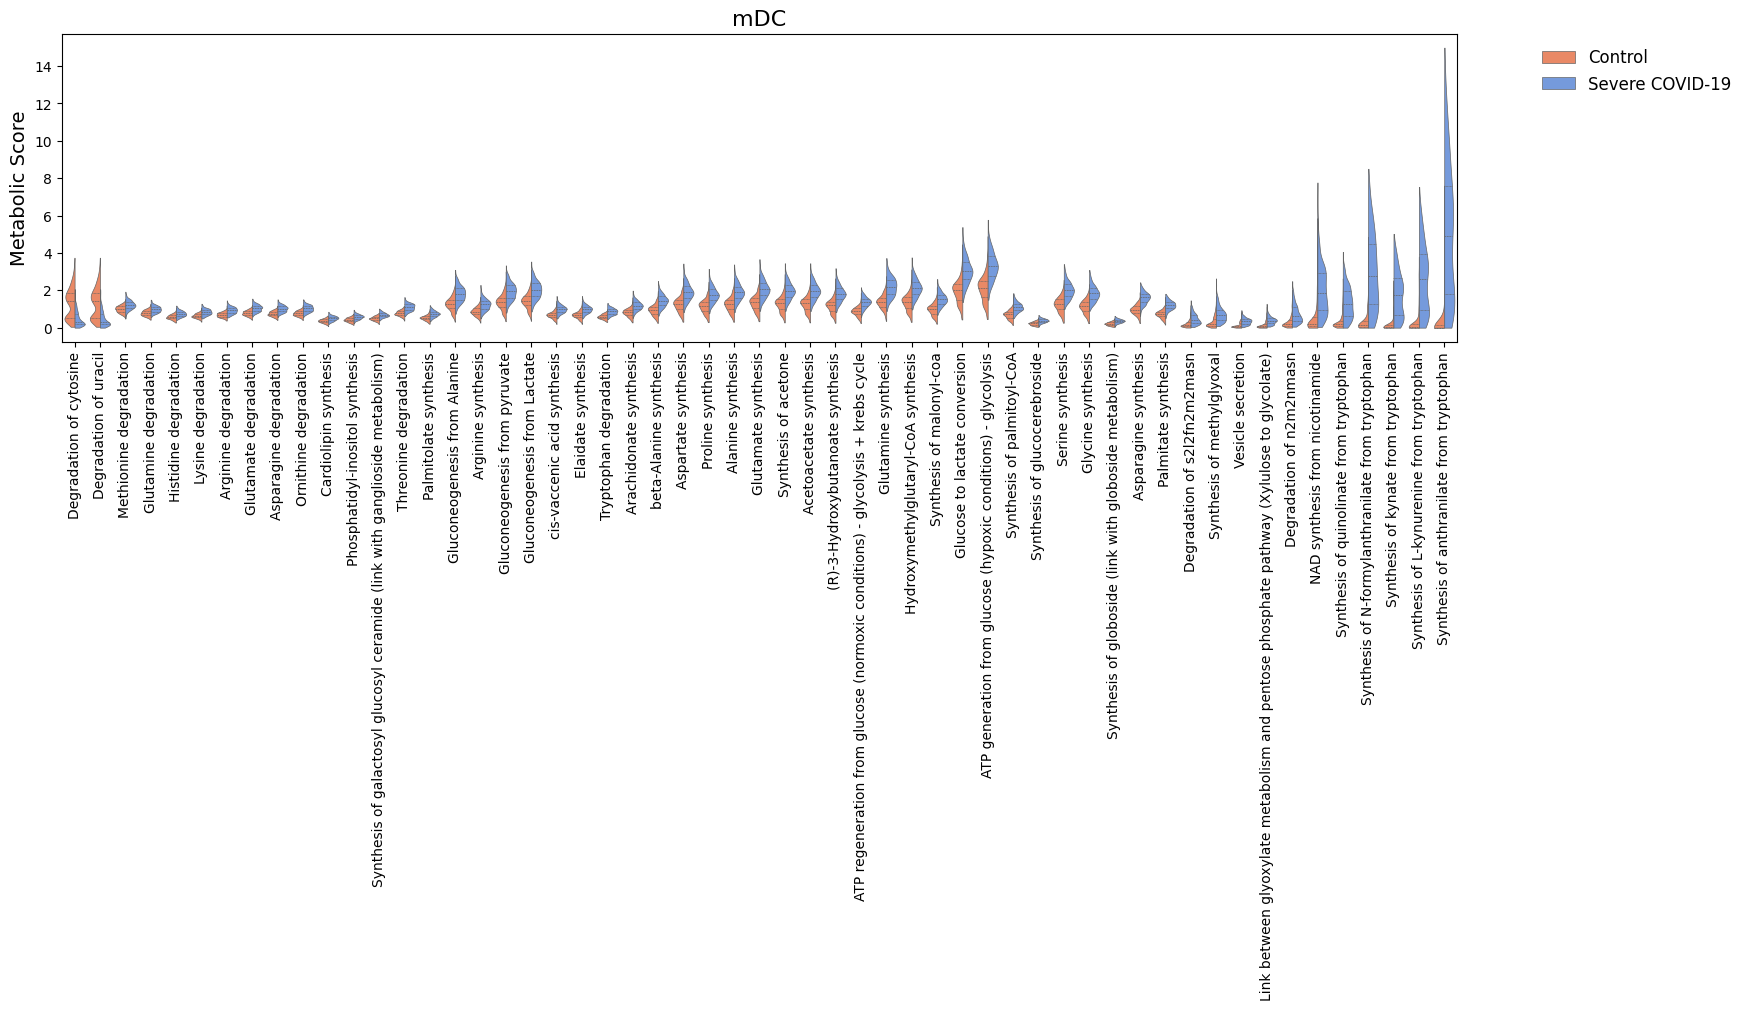

In [49]:
cell_show = ['Epithelial', 'Macrophages', 'mDC']

for c in cell_show:
    sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index]
    N = len(sig_features)
    if N > 0:
        width = min([18, 1.5 + 0.5*N])
        fig, ax = sccellfie.plotting.create_comparative_violin(adata=results['adata'].metabolic_tasks, 
                                                               significant_features=sig_features,
                                                               group1='Control', 
                                                               group2='Severe COVID-19',
                                                               condition_key=condition_key, 
                                                               cell_type_key=cell_group,
                                                               celltype=c,
                                                               xlabel='',
                                                               ylabel='Metabolic Score',
                                                               palette=['coral','cornflowerblue'],
                                                               wrapped_title_length=100,
                                                               figsize=(width, 4),
                                                               fontsize=14,
                                                               title=c,
                                                               tight_layout=False,
                                                               #save=f'DE-Dist-{cname}'
                                                              )


## Cell-cell communication

### Transfer metabolic tasks into gene expression (all variables in one AnnData object)

In [50]:
bdata = adata.copy()

In [55]:
sc.pp.log1p(bdata)

In [ ]:
results['adata'].metabolic_tasks.var['type'] = 'metabolic score'
bdata.var['type'] = 'gene expression'

In [62]:
adata_updated = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=bdata,
    adata_source=results['adata'].metabolic_tasks,
    var_names=results['adata'].metabolic_tasks.var_names
)

In [63]:
adata_updated

AnnData object with n_obs × n_vars = 63103 × 33755
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition', 'total_counts'
    var: 'type'
    uns: 'normalization', 'neighbors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### Compute cell-cell communication based on synthesis and receptor pairs

In [65]:
# Compute local colocalization scores for estradiol + ESR1
ccc_df = sccellfie.communication.compute_communication_scores(adata_updated,
    var_pairs=[('Synthesis of estradiol-17beta (E2) from androstenedione', 'ESR1'), ('Synthesis of L-kynurenine from tryptophan', 'AHR')], # List of LR pairs (synthesis task and receptor)
    groupby=cell_group,
    communication_score='gmean',
    agg_func='trimean',
    ligand_threshold=np.log(2), # Greater than this metabolic activity for consideringing it active
    receptor_threshold=0., # Greater than this expression for consideringing it active
)

In [66]:
ccc_df

sender_celltype receiver_celltype  \
0                 B                 B   
1                 B                 B   
2                 B        Epithelial   
3                 B        Epithelial   
4                 B       Macrophages   
..              ...               ...   
195             pDC                 T   
196             pDC               mDC   
197             pDC               mDC   
198             pDC               pDC   
199             pDC               pDC   

                                                ligand receptor     score  \
0    Synthesis of estradiol-17beta (E2) from andros...     ESR1  0.000000   
1            Synthesis of L-kynurenine from tryptophan      AHR  0.000000   
2    Synthesis of estradiol-17beta (E2) from andros...     ESR1  0.000000   
3            Synthesis of L-kynurenine from tryptophan      AHR  0.124446   
4    Synthesis of estradiol-17beta (E2) from andros...     ESR1  0.000000   
..                                                 ...      ...       ...   
195          Synthesis of L-kynurenine from tryptophan      AHR  0.000000   
196  Synthesis of estradiol-17beta (E2) from andros...     ESR1  0.000000   
197          Synthesis of L-kynurenine from tryptophan      AHR  0.095979   
198  Synthesis of estradiol-17beta (E2) from andros...     ESR1  0.000000   
199          Synthesis of L-kynurenine from tryptophan      AHR  0.000000   

     ligand_fraction  receptor_fraction  
0           0.050505           0.000000  
1           0.095960           0.090909  
2           0.050505           0.011173  
3           0.095960           0.414804  
4           0.050505           0.023146  
..               ...                ...  
195         0.141892           0.147710  
196         0.108108           0.007439  
197         0.141892           0.318810  
198         0.108108           0.006757  
199         0.141892           0.094595  

[200 rows x 7 columns]

### Visualize kynurenine - AHR interactions

In [67]:
kyn = ccc_df.loc[ccc_df.receptor == 'AHR'].sort_values('score', ascending=False)

In [69]:
### IMPORTANT! THRESHOLD IS ABOVE MEAN + 1 STD
### AND CELL TYPES EXPRESS LIGAND AND RECEPTOR IN MORE THAN 10% OF CELLS
kyn_thresh = kyn.score.mean() + kyn.score.std()
filtered_kyn = kyn.loc[(kyn.ligand_fraction > 0.1) & (kyn.receptor_fraction > 0.1) & (kyn.score >= kyn_thresh)]

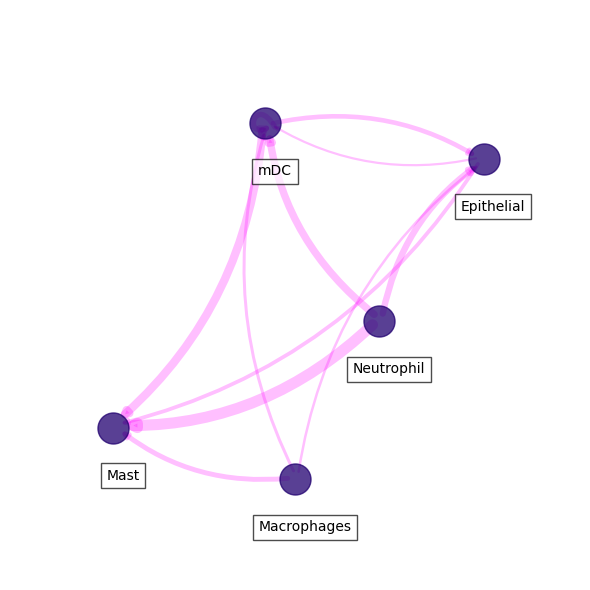

In [72]:
fig, ax = sccellfie.plotting.plot_communication_network(filtered_kyn, 
                                                        'sender_celltype', 
                                                        'receiver_celltype', 
                                                        'score', 
                                                        panel_size=(6,6),
                                                        network_layout='spring',
                                                        edge_color='magenta',
                                                        edge_width=8,
                                                        edge_arrow_size=12,
                                                        edge_alpha=0.25,
                                                        node_color='#210070',
                                                        node_size=500,
                                                        node_alpha=0.75,
                                                        node_label_size=10,
                                                        node_label_alpha=0.7,
                                                        node_label_offset=(0.05, -0.2),
                                                        title_fontsize=20,
                                                        tight_layout=True
                                                       )